# Поиск клиентов заинтересованных срочном депозите
Это практический проект по автоматическому машинному обучению с помощью H2O AutoML и Python. В этом проекте мы попробуем клафицировать уровень персонажа игры LOL по общим показателям игры. Эти данные были получены из [Kaggle](https://www.kaggle.com/vivovinco/league-of-legends-champion-stats?select=League+of+Legends+Champion+Stats+12.2.csv). 
В этом практическом проекте мы выполним следующие этапы:
* Импорт наборов данных и библиотек
* Загрузка и изучение данных
* Подготовка данных и начало работы H2O
* Запускаем H2O AutoML
* Leaderboard и Ensemble Exploration
* Исследование модели Baselearner

### Импорт наборов данных и библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML

### Загрузка и изучение данных

In [2]:
# Соединаем 2 датафрейма за 2 сезона
df_1 = pd.read_csv('League of Legends Champion Stats 12.1.csv', sep=";")
df_2 = pd.read_csv('League of Legends Champion Stats 12.2.csv', sep=";")
df = pd.concat([df_1, df_2])

In [3]:
# Инофрмация о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466 entries, 0 to 233
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    466 non-null    object 
 1   Class   465 non-null    object 
 2   Role    466 non-null    object 
 3   Tier    466 non-null    object 
 4   Score   466 non-null    float64
 5   Trend   466 non-null    float64
 6   Win %   466 non-null    object 
 7   Role %  466 non-null    object 
 8   Pick %  466 non-null    object 
 9   Ban %   466 non-null    object 
 10  KDA     466 non-null    float64
dtypes: float64(3), object(8)
memory usage: 43.7+ KB


In [4]:
# Смотрим какое значение отсутствует
df[df.isnull()["Class"]]

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA
93,Lillia,NaN,TOP,D,24.34,-9.25,49.20%,11.49%,0.40%,1.01%,1.96


In [5]:
# Заполняем отсутствующие значение исходя от имени персонажа
df[df["Name"] == "Lillia"] = df[df["Name"] == "Lillia"].fillna(method="ffill")

### Подготовка данных и начало работы H2O

In [6]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,5 mins 33 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,4 months and 4 days !!!
H2O_cluster_name:,H2O_from_python_User_ttz498
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.955 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [7]:
h2o_df = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [8]:
# Статистическая информации датафрейме
h2o_df.describe()

Rows:466
Cols:11




,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA
type,enum,enum,enum,enum,real,real,enum,string,enum,enum,real
mins,,,,,7.43,-38.03,,NaN,,,1.45
mean,,,,,50.00015021459232,-0.1911158798283263,,NaN,,,2.3310085836909877
maxs,,,,,94.23,44.71,,NaN,,,4.11
sigma,,,,,17.026518335938608,6.604691297799705,,NaN,,,0.4145976828635674
zeros,,,,,0,8,,0,,,0
missing,0,0,0,0,0,0,0,0,0,0,0
0,Aatrox,Fighter,TOP,A,58.25,6.52,49.97%,94.62%,4.43%,2.03%,1.97
1,Ahri,Mage,MID,A,53.21,-0.24,49.93%,93.47%,4.62%,1.04%,2.56
2,Akali,Assassin,MID,S,65.3,6.51,48.59%,65.65%,8.16%,12.88%,2.34


In [9]:
train, test = h2o_df.split_frame(ratios=[.80], , seed = 1234)

# Определяем предикторы
x = train.columns
y = "Tier"
x.remove(y)

### Запускаем H2O AutoML

In [19]:
# Обучаем модель
aml = H2OAutoML(max_runtime_secs=600,
                exclude_algos=['DeepLearning'],
                seed=1,
                stopping_metric='logloss',
                sort_metric='logloss',
                balance_classes=False,
                project_name='Completed',
)
%time aml.train(x=x, y=y, training_frame=train)

AutoML progress: |█
13:29:13.952: AutoML: XGBoost is not available; skipping it.
13:29:13.992: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
13:29:13.992: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.
14:00:31.90: New models will be added to existing leaderboard Completed@@Tier (leaderboard frame=null) with already 430 models.
14:00:31.183: AutoML: XGBoost is not available; skipping it.
14:00:31.188: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
14:00:31.188: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

████████
14:00:41.591: StackedEnsemble_BestOfFamily_6_AutoML_2_20220211_140031 [StackedEnsemble best_of_family_1 (built with AUTO metalearner, using top model from each algorithm type)] failed: water.exceptions.H2OIllegalArgumentException: Failed to find the xval predictions frame. . .  Looks like keep_cross_validation_predictions wasn't set when bu

### AutoML Leaderboard и Ensemble Exploration

In [20]:
# Просмотр таблицы лидеров AutoML
lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
lb  # Вывод всех строк вместо стандартных (10 строк)

model_id,logloss,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_BestOfFamily_11_AutoML_2_20220211_140031,0.261128,0.0804715,0.27173,0.0738374,18732,0.258235,StackedEnsemble
StackedEnsemble_BestOfFamily_5_AutoML_1_20220211_132913,0.358884,0.0717219,0.251302,0.0631526,3291,0.114602,StackedEnsemble
GBM_grid_2_AutoML_2_20220211_140031_model_128,0.364312,0.103323,0.318553,0.101476,647,0.221343,GBM
StackedEnsemble_BestOfFamily_10_AutoML_2_20220211_140031,0.375382,0.0787907,0.261394,0.068327,3576,0.294078,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20220211_132913,0.386658,0.145298,0.339941,0.11556,6031,0.027955,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20220211_132913,0.411854,0.143097,0.339213,0.115066,3913,0.064341,StackedEnsemble
GBM_grid_1_AutoML_1_20220211_132913_model_380,0.432635,0.132093,0.348381,0.121369,1075,0.308265,GBM
GBM_grid_2_AutoML_2_20220211_140031_model_169,0.445373,0.162483,0.368273,0.135625,404,0.199992,GBM
XRT_2_AutoML_2_20220211_140031,0.446214,0.0652102,0.37187,0.138287,207,0.03705,DRF
XRT_1_AutoML_1_20220211_132913,0.454334,0.0613728,0.372819,0.138994,352,0.048767,DRF


In [56]:
# Выбираем лучшую модель
se = aml.leader

# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

# Выводим результаты обучения, а также можно заметить из каких моделей состоит ансамбаль
# Тут можно заметить что точность модели 92%
print(metalearner)

C:\Users\User\anaconda3\lib\site-packages\h2o\estimators\stackedensemble.py:925: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  warnings.warn(


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  metalearner_AUTO_StackedEnsemble_BestOfFamily_11_AutoML_2_20220211_140031


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,multinomial,multinomial,"Elastic Net (alpha = 0.5, lambda = 0.0363 )","nlambda = 100, lambda.max = 3.4646, lambda.min = 0.0363, lambda.1s...",150,38,206,levelone_training_StackedEnsemble_BestOfFamily_11_AutoML_2_2022021...




ModelMetricsMultinomialGLM: glm
** Reported on train data. **

MSE: 0.05634405720699764
RMSE: 0.23736903169326373

ModelMetricsMultinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.07383742009915124
RMSE: 0.2717304180601635

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.922988,0.032681,0.931507,0.917647,0.972222,0.910448,0.883117
1,auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,err,0.077012,0.032681,0.068493,0.082353,0.027778,0.089552,0.116883
3,err_count,5.800000,2.588436,5.000000,7.000000,2.000000,6.000000,9.000000
4,logloss,0.258492,0.050950,0.229278,0.267297,0.192486,0.275601,0.327795
5,max_per_class_error,0.198974,0.094865,0.200000,0.153846,0.076923,0.230769,0.333333
6,mean_per_class_accuracy,0.929347,0.035716,0.941941,0.934829,0.978408,0.907035,0.884524
7,mean_per_class_error,0.070653,0.035716,0.058059,0.065171,0.021592,0.092965,0.115476
8,mse,0.072901,0.015847,0.067062,0.082985,0.047621,0.081365,0.085472
9,null_deviance,260.909940,20.012774,250.230040,283.375600,247.588010,241.620330,281.735780



Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_xval,deviance_se,alpha,iterations,training_rmse,training_logloss,training_r2,training_classification_error,training_auc,training_pr_auc
0,,2022-02-11 14:09:05,0.000 sec,1,",35E1",6,3.444914,3.450805,0.058223,0.5,NaN,,,,,,
1,,2022-02-11 14:09:05,0.009 sec,2,",33E1",7,3.432097,3.450805,0.058223,0.5,NaN,,,,,,
2,,2022-02-11 14:09:05,0.020 sec,3,",32E1",7,3.419206,3.450805,0.058223,0.5,NaN,,,,,,
3,,2022-02-11 14:09:05,0.032 sec,4,",3E1",9,3.401930,3.450805,0.058223,0.5,NaN,,,,,,
4,,2022-02-11 14:09:05,0.046 sec,5,",29E1",10,3.364212,3.423105,1.532171,0.5,5.0,0.801233,1.682106,0.792272,0.673797,NaN,NaN
5,,2022-02-11 14:09:05,0.059 sec,6,",29E1",10,3.347439,3.449187,0.057349,0.5,NaN,,,,,,
6,,2022-02-11 14:09:05,0.080 sec,8,",27E1",10,3.302915,3.457224,0.062895,0.5,NaN,,,,,,
7,,2022-02-11 14:09:05,0.102 sec,10,",26E1",10,3.252235,3.313580,1.484229,0.5,10.0,0.785653,1.626118,0.800272,0.57754,NaN,NaN
8,,2022-02-11 14:09:05,0.126 sec,12,",25E1",10,3.195587,3.443052,0.061856,0.5,NaN,,,,,,
9,,2022-02-11 14:09:05,0.167 sec,15,",24E1",10,3.125949,3.173800,1.422555,0.5,15.0,0.769202,1.562975,0.808549,0.540107,NaN,NaN



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,XRT_2_AutoML_2_20220211_140031/A,4.770938,1.000000,0.139300
1,XRT_2_AutoML_2_20220211_140031/S,4.576240,0.959191,0.133615
2,XRT_2_AutoML_2_20220211_140031/C,4.478940,0.938796,0.130774
3,XRT_2_AutoML_2_20220211_140031/God,2.833477,0.593903,0.082731
4,XRT_2_AutoML_2_20220211_140031/D,2.766558,0.579877,0.080777
5,GBM_grid_2_AutoML_2_20220211_140031_model_128/B,2.282692,0.478458,0.066649
6,GBM_grid_2_AutoML_2_20220211_140031_model_128/A,1.942449,0.407142,0.056715
7,XRT_2_AutoML_2_20220211_140031/B,1.377435,0.288714,0.040218
8,GLM_2_AutoML_2_20220211_140031/C,1.091498,0.228781,0.031869
9,DRF_2_AutoML_2_20220211_140031/A,1.051837,0.220467,0.030711



See the whole table with table.as_data_frame()



### Исследование модели Baselearner

In [48]:
# Получаем первую GBM модель
h2o_df = lb[lb["algo"] == "GBM"]
h2o_df = h2o.as_list(h2o_df, use_pandas=True)
model_name = h2o_df.iloc[0]["model_id"]
model = h2o.get_model(model_name)

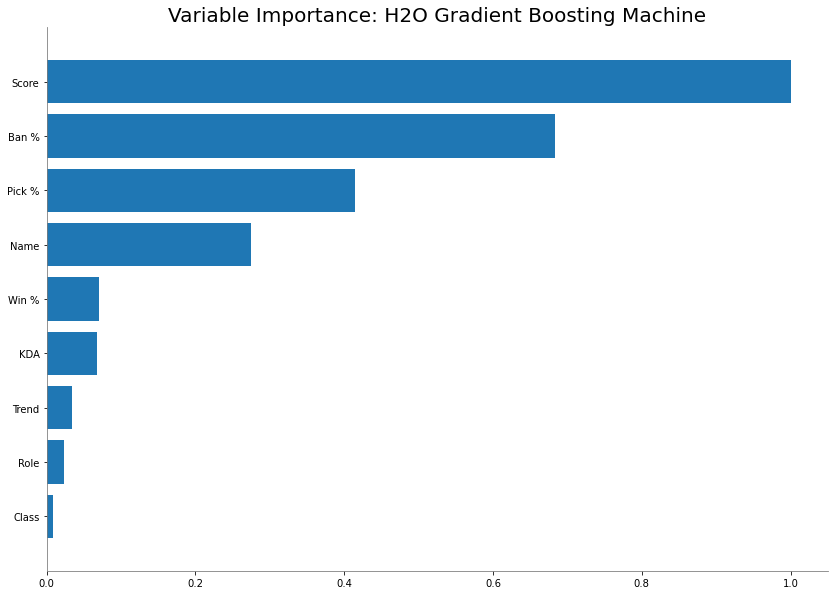

In [50]:
# Выводим важность признаков
model.varimp_plot(num_of_features=20)